In [49]:
import os
import re

import matplotlib.pyplot as ptl
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

# Carga y preprocesamiento de datos

In [21]:
names = ["image_path_str", "subclass_val", "class_label_val"]

raw_train_data = pd.read_csv("dataset/train.txt", names=names)
test_data = pd.read_csv("dataset/test.txt", names=names)
val_data = pd.read_csv("dataset/val.txt", names=names)

In [22]:
raw_train_data["class_label_txt"] = raw_train_data["image_path_str"].apply(lambda path: path.split("/")[2])
test_data["class_label_txt"] = test_data["image_path_str"].apply(lambda path: path.split("/")[2])
val_data["class_label_txt"] = val_data["image_path_str"].apply(lambda path: path.split("/")[2])

In [23]:
raw_train_data["image_path_str"] = "dataset/" + raw_train_data["image_path_str"]
test_data["image_path_str"] = "dataset/" + test_data["image_path_str"]
val_data["image_path_str"] = "dataset/" + val_data["image_path_str"]

# Entendimiento de los datos

Veamos la cantidad de imágenes totales y por producto

In [25]:
raw_train_data["class_label_txt"].value_counts()

class_label_txt
Apple                 278
Juice                 247
Milk                  182
Yoghurt               181
Melon                 154
Tomato                127
Pear                  116
Pepper                112
Potato                 75
Satsumas               70
Soy-Milk               60
Orange                 57
Soyghurt               51
Sour-Cream             48
Kiwi                   46
Banana                 45
Carrots                43
Lemon                  42
Avocado                41
Brown-Cap-Mushroom     39
Onion                  38
Peach                  37
Nectarine              36
Red-Grapefruit         34
Oatghurt               33
Mango                  32
Oat-Milk               32
Lime                   31
Sour-Milk              30
Zucchini               30
Cucumber               28
Passion-Fruit          28
Pineapple              26
Pomegranate            26
Garlic                 25
Leek                   23
Plum                   22
Aubergine             

<Axes: xlabel='class_label_txt'>

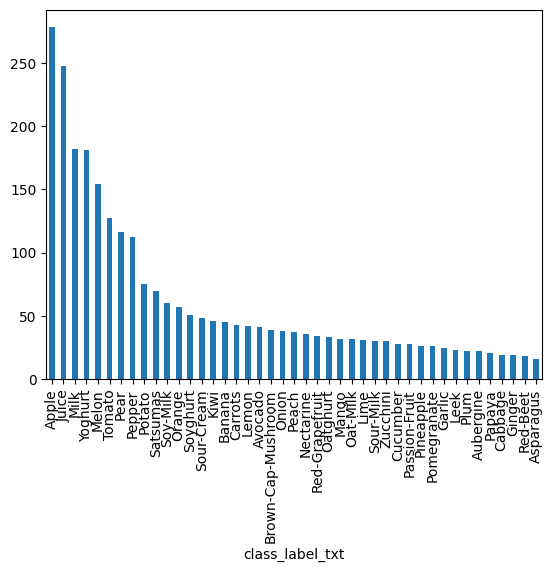

In [74]:
raw_train_data["class_label_txt"].value_counts().plot.bar()

In [26]:
len(raw_train_data["class_label_txt"])

2640

En total se tienen 2640,debido a que es una cantidad muy pequeña de imágenes, se hará una aumentación del conjunto de entrenamiento mediante diferentes transformaciones como cambios de brillo, contraste y rotaciones.

In [ ]:
class_labels = {
    class_label_txt: class_label_val for class_label_val, class_label_txt in enumerate(raw_train_data["class_label_txt"].unique())
}

In [ ]:
raw_train_data_path = raw_train_data["image_path_str"].to_list()

## Aumentación de datos

In [ ]:
def augment_image(image):
    # Rotations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Brightness variation
    image = tf.image.random_brightness(image, 0.02)
    # Contrast variation
    image = tf.image.random_contrast(image, 0.1, 0.6)
    return image

for file_path in raw_train_data_path:
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Generate two images by each train image
    for i in range(2):
        augmented_image = augment_image(image)

        # Save augmented images
        new_file_name = f"{file_path[:-4]}_augmented_{i}.jpg"
        new_file_path = os.path.join(new_file_name)
        Image.fromarray(augmented_image.numpy()).save(new_file_path)

print("Aumentación de datos completada.")

2024-11-17 14:49:18.477829: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Aumentación de datos completada.


In [28]:
train_data_augmented_0 = raw_train_data.copy(deep=True)
train_data_augmented_1 = raw_train_data.copy(deep=True)

In [29]:
train_data_augmented_0["image_path_str"] = train_data_augmented_0["image_path_str"].apply(lambda path: path[:-4] + "_augmented_0.jpg")[0]
train_data_augmented_1["image_path_str"] = train_data_augmented_1["image_path_str"].apply(lambda path: path[:-4] + "_augmented_1.jpg")[0]

In [30]:
train_data = pd.concat([raw_train_data, train_data_augmented_0, train_data_augmented_1])

Veamos ahora la nueva cantidad de imágenes después de realizar la aumentación

In [32]:
train_data["class_label_txt"].value_counts()

class_label_txt
Apple                 834
Juice                 741
Milk                  546
Yoghurt               543
Melon                 462
Tomato                381
Pear                  348
Pepper                336
Potato                225
Satsumas              210
Soy-Milk              180
Orange                171
Soyghurt              153
Sour-Cream            144
Kiwi                  138
Banana                135
Carrots               129
Lemon                 126
Avocado               123
Brown-Cap-Mushroom    117
Onion                 114
Peach                 111
Nectarine             108
Red-Grapefruit        102
Oatghurt               99
Mango                  96
Oat-Milk               96
Lime                   93
Sour-Milk              90
Zucchini               90
Cucumber               84
Passion-Fruit          84
Pineapple              78
Pomegranate            78
Garlic                 75
Leek                   69
Plum                   66
Aubergine             

<Axes: xlabel='class_label_txt'>

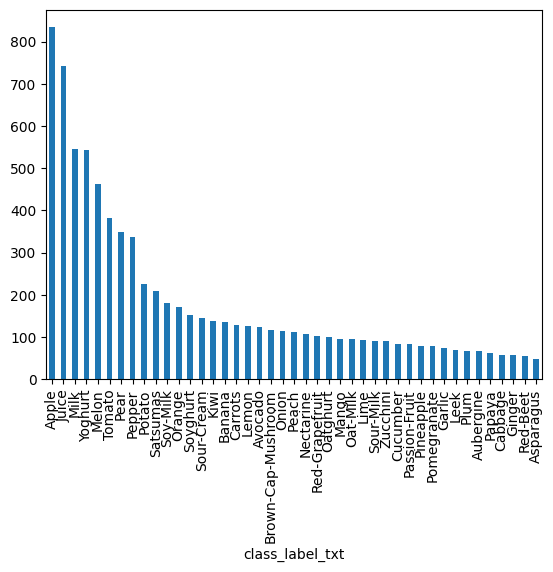

In [78]:
train_data["class_label_txt"].value_counts().plot.bar()

In [34]:
len(train_data["class_label_txt"])

7920

In [36]:
train_data_path = train_data["image_path_str"].to_list()
test_data_path = test_data["image_path_str"].to_list()
val_data_path = val_data["image_path_str"].to_list()

train_data_labels = train_data["class_label_val"].to_list()
test_data_labels = test_data["class_label_val"].to_list()
val_data_labels = val_data["class_label_val"].to_list()

In [ ]:
# GEnerate datasets so as to train CNN model
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resizing
    image = tf.image.resize(image, [128, 128])
    # Normalization
    image = image / 255.0

    return image, label

def create_dataset(file_paths, labels, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [44]:
train_dataset = create_dataset(train_data_path, train_data_labels)
test_dataset = create_dataset(test_data_path, test_data_labels)
val_dataset = create_dataset(val_data_path, val_data_labels)

### A continuación veremos algunas imágenes del conjunto de entrenamiento

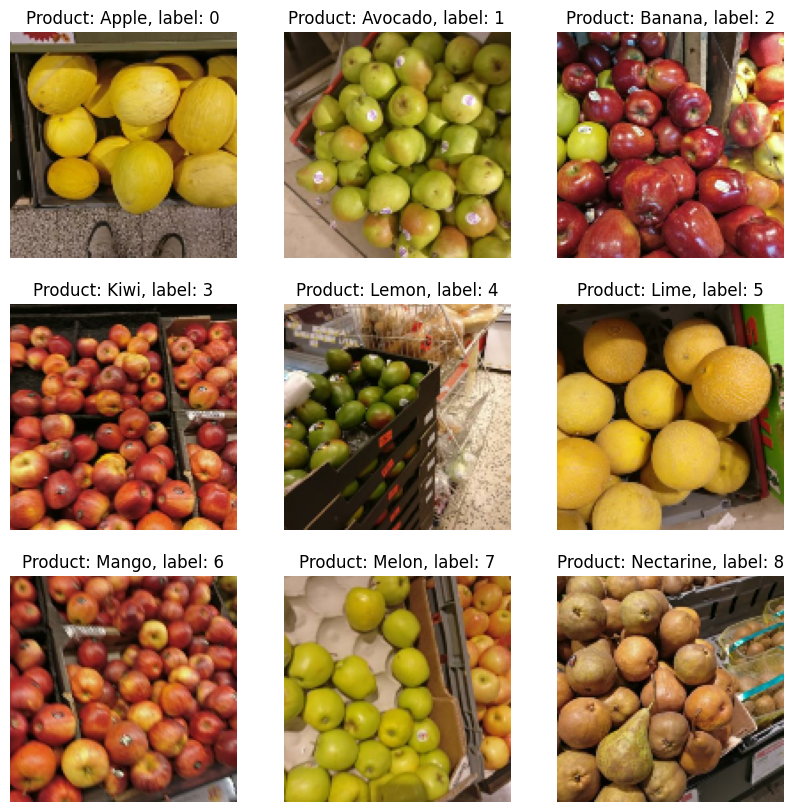

2024-11-17 11:02:38.429886: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
key_list = list(class_labels.keys())
val_list = list(class_labels.values())

for images, labels in train_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        position = val_list.index(i)
        plt.title(f"Product: {key_list[position]}, label: {i}")
        plt.axis('off')  # Quitar los ejes
    plt.show()

# Entrenamiento del primero modelo. Red Neuronal Convolucional

In [39]:
num_classes = len(class_labels.values())

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,455,851 (28.44 MB)

 Trainable params: 7,455,851 (28.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Usa 'categorical_crossentropy' si las etiquetas están one-hot encoded
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    callbacks=early_stopping
)

Epoch 1/15


2024-11-17 15:10:15.362438: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040449536 exceeds 10% of free system memory.
2024-11-17 15:10:18.009130: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040449536 exceeds 10% of free system memory.


 1/62 ━━━━━━━━━━━━━━━━━━━━ 5:55 6s/step - accuracy: 0.2812 - loss: 2.7467

2024-11-17 15:10:19.569459: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040449536 exceeds 10% of free system memory.
2024-11-17 15:10:21.780675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040449536 exceeds 10% of free system memory.


 2/62 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.2754 - loss: 2.7607

2024-11-17 15:10:23.256354: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040449536 exceeds 10% of free system memory.


62/62 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.1277 - loss: 3.4669 - val_accuracy: 0.0805 - val_loss: 3.4575
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.1277 - loss: 3.3489 - val_accuracy: 0.0885 - val_loss: 3.4285
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.1150 - loss: 3.3675 - val_accuracy: 0.0656 - val_loss: 3.4267
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.0994 - loss: 3.3298 - val_accuracy: 0.1565 - val_loss: 3.3599
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.1169 - loss: 3.3030 - val_accuracy: 0.1095 - val_loss: 3.3335
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.1473 - loss: 3.2170 - val_accuracy: 0.0913 - val_loss: 3.4365
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.1532 - loss: 3.2394 - val_accuracy: 0.1779 - val_loss: 3.2241
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.1604 - loss: 3.1661 - val_accuracy: 0.0974 - val_loss: 3.

### Veamoslas métricas del modelo entrenado

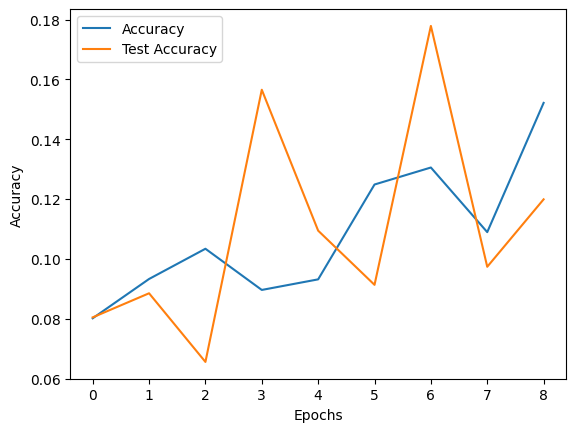

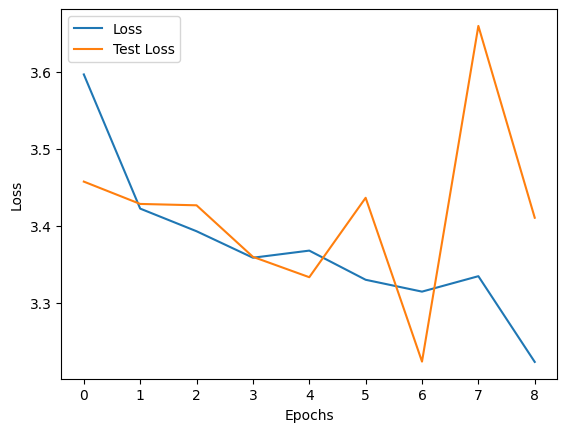

In [46]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
loss, accuracy = model.evaluate(test_dataset)

print(f"Pérdida en validación: {loss}")
print(f"Precisión en validación: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 909ms/step - accuracy: 0.1540 - loss: 3.3269
Pérdida en validación: 3.2240710258483887
Precisión en validación: 0.17786720395088196


In [47]:
loss, accuracy = model.evaluate(val_dataset)

print(f"Pérdida en validación: {loss}")
print(f"Precisión en validación: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - accuracy: 0.1206 - loss: 3.3661
Pérdida en validación: 3.3566505908966064
Precisión en validación: 0.11824323982000351


In [64]:
# Obtener las predicciones del modelo
predictions = model.predict(test_dataset)  # Generar predicciones

# Convert probabilities into class
y_pred_cnn = np.argmax(predictions, axis=1)
y_true = test_data["class_label_val"]

# Imprimir el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_cnn))

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 909ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.13      0.59      0.22       276
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00       153
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        56
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        36
          13       0.00      0.00      0.00       108
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        22
          16 

/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

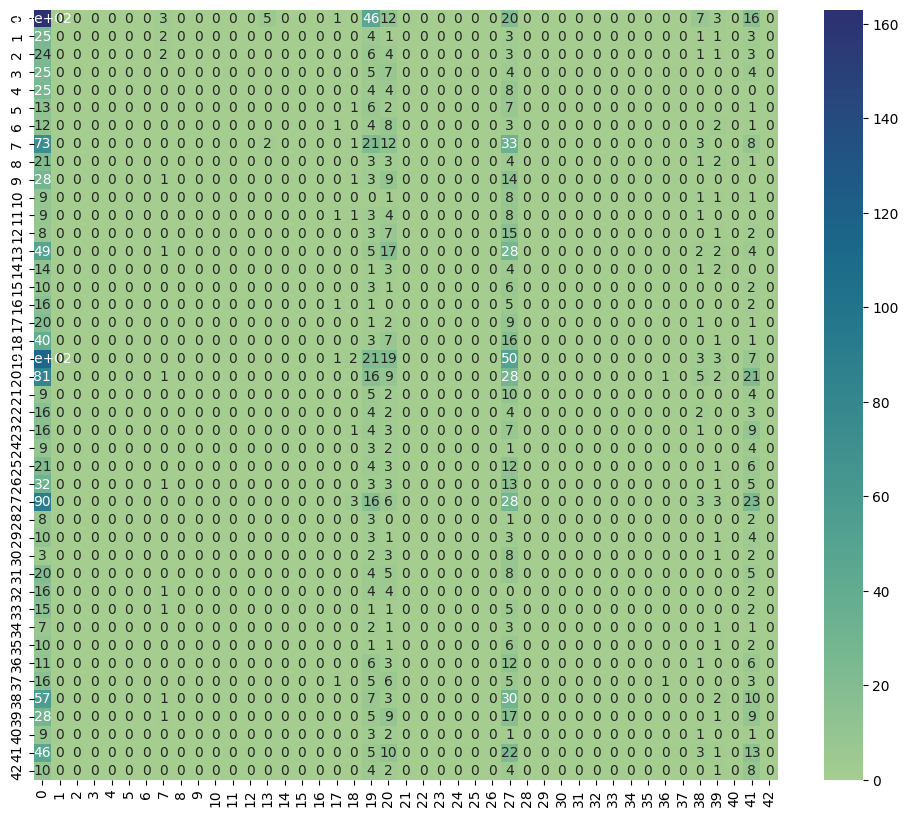

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, y_pred_cnn), annot=True, cmap="crest", ax=ax)

In [58]:
# Obtener las predicciones del modelo
predictions = model.predict(val_dataset)  # Generar predicciones

# Convert probabilities into class
y_pred_cnn = np.argmax(predictions, axis=1)
y_true = val_data["class_label_val"]

# Imprimir el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_cnn))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.07      0.45      0.12        22
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.20      0.05      0.08        20
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         5
          19    

/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

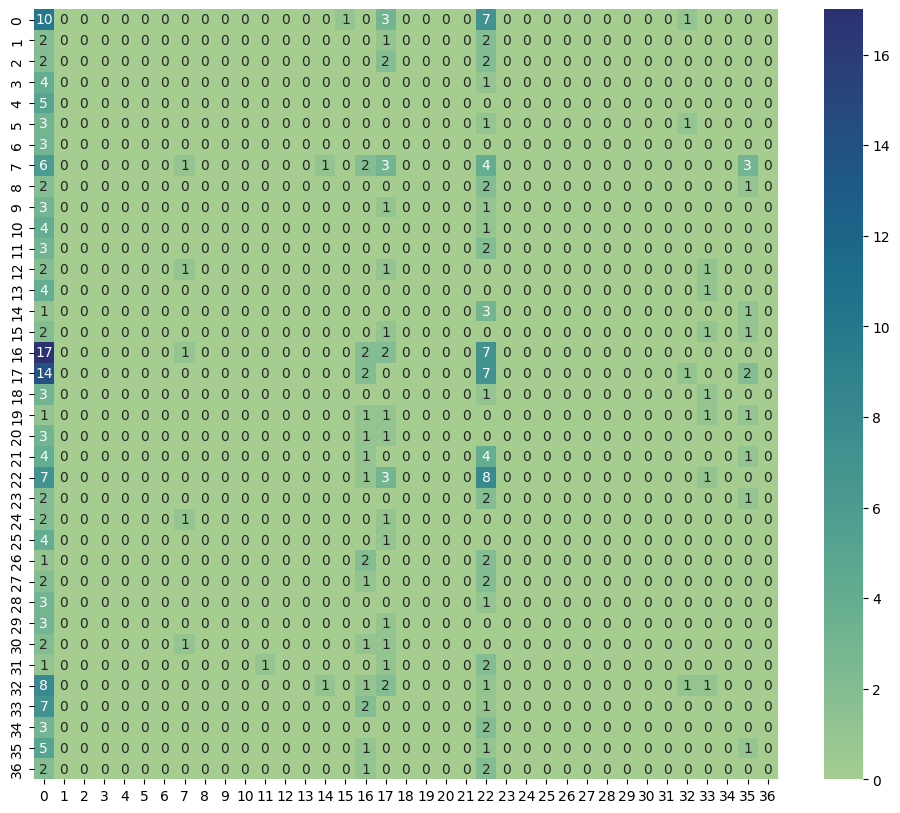

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, y_pred_cnn), annot=True, cmap="crest", ax=ax)

## Preprocesamiento para entrenar el segundo modelo. Random Forest

In [ ]:
def generate_array_data(data: pd.DataFrame):
    train_image_array = []

    target_size = (128, 128)

    for file_path in data["image_path_str"]:        
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3)
        # Resizing
        image = tf.image.resize(image, target_size)
        # Normalization
        image = image / 255.0
        
        train_image_array.append(image.numpy())

    # Convert images into numpy arrays
    train_image_array = np.array(train_image_array)

    print(f"Dimension of datasets: {train_image_array.shape}")

    return train_image_array

In [68]:
train_data_darray = generate_array_data(train_data)
test_data_darray = generate_array_data(test_data)
val_data_darray = generate_array_data(val_data)

Dimension of datasets: (7920, 128, 128, 3)
Dimension of datasets: (2485, 128, 128, 3)
Dimension of datasets: (296, 128, 128, 3)


In [69]:
train_data_darray = train_data_darray.reshape(7920, 49152)
test_data_darray = test_data_darray.reshape(2485, 49152)
val_data_darray = val_data_darray.reshape(296, 49152)

## Instacia del modelo

In [70]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_model.fit(train_data_darray, train_data["class_label_val"])

RandomForestClassifier(max_depth=5, random_state=0)

## Veamos las métricas obtenidas

In [71]:
y_pred_random_forest = random_forest_model.predict(test_data_darray)

<Axes: >

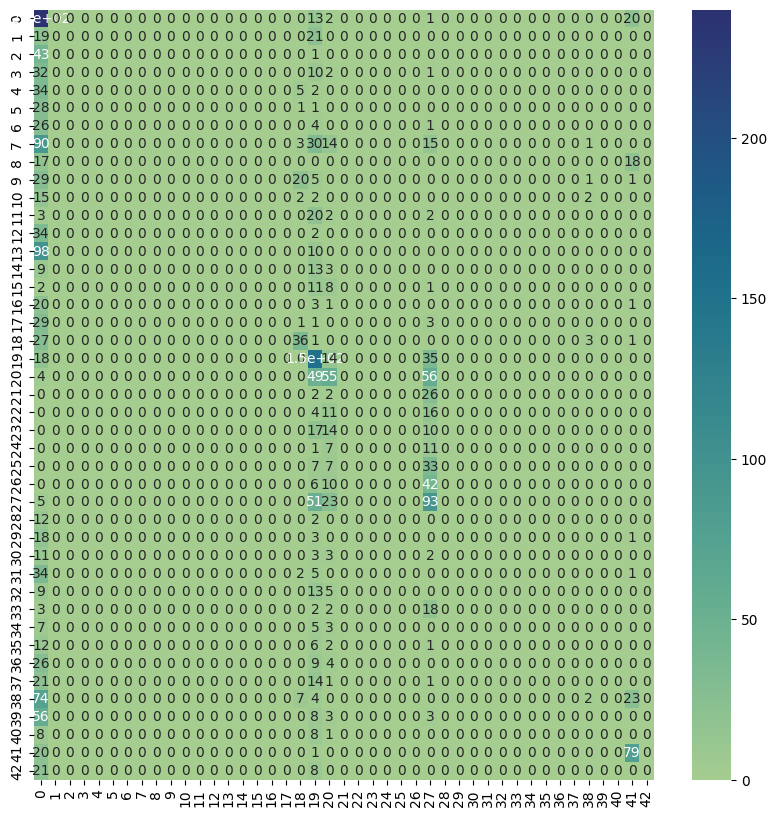

In [72]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, y_pred_random_forest), annot=True, cmap="crest", ax=ax)

In [73]:
print(classification_report(y_true, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.21      0.87      0.34       276
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00       153
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        56
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        36
          13       0.00      0.00      0.00       108
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00        25
          17       0.00    

/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emil/anaconda3/envs/ciencia_de_datos/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif